In [1]:
import os

NUM_THREADS = "1"

os.environ["OMP_NUM_THREADS"] = NUM_THREADS
os.environ["OPENBLAS_NUM_THREADS"] = NUM_THREADS
os.environ["MKL_NUM_THREADS"] = NUM_THREADS
os.environ["VECLIB_MAXIMUM_THREADS"] = NUM_THREADS
os.environ["NUMEXPR_NUM_THREADS"] = NUM_THREADS

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.colors
import os
from utils.SHIPS_preprocess import SHIPS_train_test_split, calc_d24_VMAX, fore_hr_averaging, SHIPS_train_test_shuffle_CLASS
from utils.SHIPS_preprocess import load_processed_SHIPS, calculate_class_weights, get_RI_classes
from utils.SHIPS_ML_model_funcs import apply_class_label, calc_CM_stats, get_scores_class_rept, get_roc_auc, get_feature_importances_RF
from utils.SHIPS_ML_model_funcs import get_confusion_matrix_RF, get_scores_best_params_RF, create_gridsearch_RF, get_train_test_split
from utils.SHIPS_ML_model_funcs import get_confusion_matrix_LR, get_scores_best_params_LR, create_gridsearch_LR, get_feature_importances_LR
from utils.SHIPS_ML_model_funcs import calc_AUPD, calculate_PD_curves
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix,accuracy_score,precision_score,recall_score,classification_report
from sklearn.metrics import precision_recall_curve, auc, f1_score, fbeta_score,brier_score_loss
from sklearn.inspection import permutation_importance
import matplotlib.colors
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from utils.SHIPS_ML_model_funcs_imblearn import create_gridsearch_RF_sampler
from utils import SHIPS_plotting
import pickle

##### Model evaluation

In [3]:
def evaluate_model_RF(model,X_test,y_test,basin,fold,model_name,test_years,label_names,ncats,scoring):
    # Classification report
    report, y_true, y_pred = get_scores_best_params_RF(model,X_test,y_test,basin)
    report['Years Out'] = str(test_years)
    report['Model'] = model_name
    report['Fold'] = i
    # Confusion matrix
    cm_stats = get_confusion_matrix_RF(model,y_true,y_pred,basin,label_names,ncats)
    cm_stats['Years Out'] = str(test_years)
    cm_stats['Model'] = model_name
    cm_stats['Fold'] = i
    # Feature importances
    fi_pred = get_feature_importances_RF(model,X_test,y_test,basin,scoring)
    fi_pred['Years Out'] = str(test_years)
    fi_pred['Model'] = model_name
    fi_pred['Fold'] = i
    # ROC curve / AUC scores
    ypred_prob, p_vs_r, roc_vals, brier = get_roc_auc(X_test,basin,model,y_test,1,'R1',scoring,'equal')
    p_vs_r['Years Out'] = str(test_years)
    p_vs_r['Model'] = model_name
    p_vs_r['Fold'] = i
    roc_vals['Fold'] = i
    roc_vals['Model'] = model_name
    roc_vals['Years Out'] = str(test_years)
    brier['Years Out'] = str(test_years)
    brier['Model'] = model_name
    brier['Fold'] = i
    # Get actual predictions of target variable Y
    if basin != 'ALL':
        y_pred_all = y_test.xs(basin).copy()
    else:
        y_pred_all = y_test.copy()
    # Save predicted values of y
    y_pred_all['Y pred'] = y_pred
    y_pred_all['Y true'] = y_true
    y_pred_all['Predicted Basin'] = basin
    y_pred_all['Model'] = model_name
    # Get probabilities for 0 (not-RI) and 1 (RI)
    y_pred_all['Y pred probab (class: 0)'] = ypred_prob[:,0]
    y_pred_all['Y pred probab (class: 1)'] = ypred_prob[:,1]
    #
    return y_pred_all,roc_vals,brier,p_vs_r,fi_pred,cm_stats,report

##### Model evaluation--logistic regression

In [4]:
def evaluate_model_LR(model,X_test,y_test,basin,fold,model_name,test_years,label_names,ncats,scoring):
    # Classification report
    report, y_true, y_pred = get_scores_best_params_LR(model,X_test,y_test,basin)
    report['Years Out'] = str(test_years)
    report['Model'] = model_name
    report['Fold'] = i
    # Confusion matrix
    cm_stats = get_confusion_matrix_LR(model,y_true,y_pred,basin,label_names,ncats)
    cm_stats['Years Out'] = str(test_years)
    cm_stats['Model'] = model_name
    cm_stats['Fold'] = i
    # Feature importances
    fi_pred = get_feature_importances_LR(model,X_test,y_test,basin,scoring)
    fi_pred['Years Out'] = str(test_years)
    fi_pred['Model'] = model_name
    fi_pred['Fold'] = i
    # ROC curve / AUC scores
    ypred_prob, p_vs_r, roc_vals, brier = get_roc_auc(X_test,basin,model,y_test,1,'R1',scoring,'equal')
    p_vs_r['Years Out'] = str(test_years)
    p_vs_r['Model'] = model_name
    p_vs_r['Fold'] = i
    roc_vals['Fold'] = i
    roc_vals['Model'] = model_name
    roc_vals['Years Out'] = str(test_years)
    brier['Years Out'] = str(test_years)
    brier['Model'] = model_name
    brier['Fold'] = i
    # Get actual predictions of target variable Y
    if basin != 'ALL':
        y_pred_all = y_test.xs(basin).copy()
    else:
        y_pred_all = y_test.copy()
    # Save predicted values of y
    y_pred_all['Y pred'] = y_pred
    y_pred_all['Y true'] = y_true
    y_pred_all['Predicted Basin'] = basin
    y_pred_all['Model'] = model_name
    # Get probabilities for 0 (not-RI) and 1 (RI)
    y_pred_all['Y pred probab (class: 0)'] = ypred_prob[:,0]
    y_pred_all['Y pred probab (class: 1)'] = ypred_prob[:,1]
    #
    return y_pred_all,roc_vals,brier,p_vs_r,fi_pred,cm_stats,report

##### Load experiments

In [5]:
fpath_load = 'DATA/ML_model_results/TRAINING/all_models_ROS_and_SMOTE/'
train_yr_start = 2005
train_yr_end = 2018
mask_TYPE = 'SIMPLE'
is_stand = True
if is_stand:
    stand_str = 'STANDARDIZED'
else:
    stand_str = 'no_STANDARD'
RI_thresh = 30
wts_str = 'default'
score = 'f1_weighted'
N_samples = 25

#### Load Confusion Matrix, precision vs recall

In [6]:
path_suff = 'TRAIN_SHIPS_vs_no_RI_{yr_start}-{yr_end}_{mask_TYPE}_MASK_{stand_str}_RI_thresh_{RI_thresh}'\
'_{N}_samples_{scoring}.csv'.format(yr_start=train_yr_start,yr_end=train_yr_end,mask_TYPE=mask_TYPE,
                           stand_str=stand_str,RI_thresh=RI_thresh,N=N_samples,scoring=score)
cm_res = pd.read_csv(fpath_load+'Conf_Matrix'+path_suff)

In [7]:
cm_res.groupby(['Model','BASIN','Fold']).count()

Unnamed: 0  False Alarms  \
Model                             BASIN        Fold                             
Logistic Reg.                     ALL          0              2             2   
                                               1              2             2   
                                               2              2             2   
                                               3              2             2   
                                               4              2             2   
...                                                         ...           ...   
Random Forest (random oversample) WEST_PACIFIC 20             2             2   
                                               21             2             2   
                                               22             2             2   
                                               23             2             2   
                                               24             2             2   

                                                     POD  Category Names  \
Model                             BASIN        Fold                        
Logistic Reg.                     ALL          0       2               2   
                                               1       2               2   
                                               2       2               2   
                                               3       2               2   
                                               4       2               2   
...                                                  ...             ...   
Random Forest (random oversample) WEST_PACIFIC 20      2               2   
                                               21      2               2   
                                               22      2               2   
                                               23      2               2   
                                               24      2               2   

                                                     PFOD  Category  FAR  \
Model                             BASIN        Fold                        
Logistic Reg.                     ALL          0        2         2    2   
                                               1        2         2    2   
                                               2        2         2    2   
                                               3        2         2    2   
                                               4        2         2    2   
...                                                   ...       ...  ...   
Random Forest (random oversample) WEST_PACIFIC 20       2         2    2   
                                               21       2         2    2   
                                               22       2         2    2   
                                               23       2         2    2   
                                               24       2         2    2   

                                                     Correct Negs  \
Model                             BASIN        Fold                 
Logistic Reg.                     ALL          0                2   
                                               1                2   
                                               2                2   
                                               3                2   
                                               4                2   
...                                                           ...   
Random Forest (random oversample) WEST_PACIFIC 20               2   
                                               21               2   
                                               22               2   
                                               23               2   
                                               24               2   

                                                     N_predicted  Hits  ...  \
Model                             BASIN     

##### Identify best model parameters
There are a lot of ways to do this. We select the best model based on `CSI` (but you could use a different metric if you wanted, like best `PoD`, lowest `FAR`, highest `recall`, etc.).  We select the model that performs best on our all-basin predictions (but again, could make a different choice)

In [8]:
cm_max_threat = cm_res.set_index(['Category Names','BASIN','Model']).sort_values(by=['BASIN','Model','Threat'],
                                                                                ascending=[True,True,False])
basin_ALL = cm_res['BASIN'].unique().tolist()
cm_max_best = pd.DataFrame()
for ibasin in basin_ALL:
    icm = cm_max_threat.drop(columns={'Unnamed: 0','Category'}).xs(('RI',ibasin)).iloc[np.arange(0,100,25)]
    icm['BASIN'] = ibasin
    cm_max_best = cm_max_best.append(icm.reset_index(),ignore_index=True)

/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2947: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


#### Load SHIPS predictors

In [9]:
def load_processed_SHIPS(yr_start,yr_end,mask_TYPE,max_fore,interp_str,use_basin='ALL'):
    SHIPS_predictors = pd.DataFrame()
    fpath_load = 'DATA/processed/'
    if use_basin == 'ALL':
        BASIN = ['ATLANTIC','EAST_PACIFIC','WEST_PACIFIC','SOUTHERN_HEM']
    else:
        BASIN = [use_basin]
    #
    for i_name in BASIN:
        fname_load = fpath_load+'SHIPS_processed_{BASIN}_set_yrs_{yr_start}-{yr_end}_max_fore_hr_{max_fore}_{interp_str}_'\
        'land_mask_{mask_TYPE}.csv'.format(BASIN=i_name,yr_start=yr_start,yr_end=yr_end,
                                          max_fore=max_fore,interp_str=interp_str,mask_TYPE=mask_TYPE)
        print(fname_load)
        iload = pd.read_csv(fname_load)
        # Change RSST / RHCN to NSST / NOHC just to keep naming consistent
        if (i_name != 'ATLANTIC') | (i_name != 'EAST_PACIFIC'):
            iload = iload.rename(columns={'RSST':'NSST','RHCN':'NOHC'})
        #
        iload['BASIN'] = i_name
        SHIPS_predictors = SHIPS_predictors.append(iload)
        #
    SHIPS_predictors = SHIPS_predictors.drop(columns={'level_0','index'})
    return SHIPS_predictors,BASIN

In [10]:
max_fore = 24 # maximum forecast hours
mask_TYPE = 'SIMPLE_MASK' # how are we handling the land mask?
interp_str = 'INTERP' # did we interpolate?
yr_start = 2005
yr_start_TEST = 2019
yr_end_LOAD = 2021
yr_end_TRAIN = 2018
use_basin = 'ALL'

SHIPS_predictors,BASIN = load_processed_SHIPS(yr_start,yr_end_LOAD,mask_TYPE,max_fore,interp_str,use_basin)
#
FULL_yrs = np.arange(yr_start,yr_end_LOAD+1,1)
SHIPS_predictors = SHIPS_predictors[pd.to_datetime(SHIPS_predictors['DATE_full']).dt.year.isin(FULL_yrs)]

DATA/processed/SHIPS_processed_ATLANTIC_set_yrs_2005-2021_max_fore_hr_24_INTERP_land_mask_SIMPLE_MASK.csv
DATA/processed/SHIPS_processed_EAST_PACIFIC_set_yrs_2005-2021_max_fore_hr_24_INTERP_land_mask_SIMPLE_MASK.csv
DATA/processed/SHIPS_processed_WEST_PACIFIC_set_yrs_2005-2021_max_fore_hr_24_INTERP_land_mask_SIMPLE_MASK.csv
DATA/processed/SHIPS_processed_SOUTHERN_HEM_set_yrs_2005-2021_max_fore_hr_24_INTERP_land_mask_SIMPLE_MASK.csv


In [11]:
SHIPS_predictors.groupby(['BASIN',pd.to_datetime(SHIPS_predictors['DATE_full']).dt.year]).count()

CASE  TIME  ATCFID  NAME  DATE_full   DTL  TYPE  SHRG  \
BASIN        DATE_full                                                          
ATLANTIC     2005       4690  4690    4690  4690       4690  3668  3739  2770   
             2006       1890  1890    1890  1890       1890  1696  1719  1243   
             2007       1540  1540    1540  1540       1540  1087  1155   850   
             2008       2905  2905    2905  2905       2905  1819  1906  1401   
             2009       1085  1085    1085  1085       1085   922   946   693   
...                      ...   ...     ...   ...        ...   ...   ...   ...   
WEST_PACIFIC 2017       4039  4039    4039  4039       4039  3116  3272  2397   
             2018       5670  5670    5670  5670       5670  4498  4726  3382   
             2019       4746  4746    4746  4746       4746  3817  4018  2870   
             2020       3178  3178    3178  3178       3178  2424  2596  1858   
             2021       4256  4256    4256  4256       4256  3349  3500  2502   

                        D200  Z850  ...   POT  GOES Tb  s(GOES Tb)  \
BASIN        DATE_full              ...                              
ATLANTIC     2005       2770  2770  ...  2525     3654        3689   
             2006       1243  1243  ...  1197     1680        1701   
             2007        850   850  ...   728     1120        1127   
             2008       1401  1401  ...  1218     1890        1918   
             2009        693   693  ...   650      938         931   
...                      ...   ...  ...   ...      ...         ...   
WEST_PACIFIC 2017       2397  2397  ...  2132     3164        3199   
             2018       3382  3382  ...  3081     4592        4627   
             2019       2870  2870  ...  2640     3885        3892   
             2020       1858  1858  ...  1612     2422        2422   
             2021       2502  2502  ...  2283     3416        3444   

                        pct < -50C  storm size   PC1   PC2   PC3   PC4  \
BASIN        DATE_full                                                   
ATLANTIC     2005             3899        4025  3654  3654  3689  3710   
             2006             1729        1855  1687  1680  1701  1715   
             2007             1337        1407  1127  1120  1127  1148   
             2008             2135        2366  1862  1890  1918  1932   
             2009             1008        1029   917   938   931   945   
...                            ...         ...   ...   ...   ...   ...   
WEST_PACIFIC 2017             3500        3773  3129  3164  3199  3227   
             2018             4781        4963  4571  4592  4627  4655   
             2019             4018        4277  3871  3885  3892  3892   
             2020             2611        2814  2408  2422  2422  2422   
             2021             3640        3913  3395  3416  3444  3472   

                        CYCLONE NO  
BASIN        DATE_full              
ATLANTIC     2005             4690  
             2006             1890  
             2007             1540  
             2008             2905  
             2009             1085  
...                            ...  
WEST_PACIFIC 2017             4039  
             2018             5670  
             2019             4746  
             2020             3178  
             2021             4256  

[68 rows x 27 columns]

In [12]:
SHIPS_predictors.set_index(['BASIN']).xs('ATLANTIC')['ATCFID'].unique()

array(['AL012005', 'AL022005', 'AL032005', 'AL042005', 'AL052005',
       'AL062005', 'AL072005', 'AL082005', 'AL092005', 'AL102005',
       'AL112005', 'AL122005', 'AL132005', 'AL142005', 'AL152005',
       'AL162005', 'AL172005', 'AL182005', 'AL192005', 'AL202005',
       'AL212005', 'AL222005', 'AL232005', 'AL242005', 'AL252005',
       'AL262005', 'AL272005', 'AL282005', 'AL292005', 'AL302005',
       'AL312005', 'AL012006', 'AL022006', 'AL032006', 'AL042006',
       'AL052006', 'AL062006', 'AL072006', 'AL082006', 'AL092006',
       'AL102006', 'AL012007', 'AL022007', 'AL032007', 'AL042007',
       'AL052007', 'AL062007', 'AL072007', 'AL082007', 'AL092007',
       'AL102007', 'AL112007', 'AL122007', 'AL132007', 'AL142007',
       'AL152007', 'AL162007', 'AL172007', 'AL012008', 'AL022008',
       'AL032008', 'AL042008', 'AL052008', 'AL062008', 'AL072008',
       'AL082008', 'AL092008', 'AL102008', 'AL112008', 'AL122008',
       'AL132008', 'AL142008', 'AL152008', 'AL162008', 'AL1720

#### Train best-guess ML model
We'll construct the best-guess ML model from our optimal hyperparameters, identified above. We'll train the model once on our entire training period, 2005-2018

Identify best parameters

In [13]:
cm_max_sel = cm_max_best.set_index(['BASIN','Model']).xs('ALL')
C_vals = [cm_max_sel.xs('Logistic Reg.')['C']]
max_iter = [cm_max_sel.xs('Logistic Reg.')['Max Iter'].astype(int)]
#
cw_max_depth = [cm_max_sel.xs('Random Forest (class wt)')['Max Depth'].astype(int)]
cw_max_feat = [cm_max_sel.xs('Random Forest (class wt)')['Max Features'].astype(int)]
cw_n_est = [cm_max_sel.xs('Random Forest (class wt)')['N Estimators'].astype(int)]
cw_min_samp_leaf = [cm_max_sel.xs('Random Forest (class wt)')['Min Samples Leaf'].astype(int)]
#
smote_max_depth = [cm_max_sel.xs('Random Forest (SMOTE)')['Max Depth'].astype(int)]
smote_max_feat = [cm_max_sel.xs('Random Forest (SMOTE)')['Max Features'].astype(int)]
smote_n_est = [cm_max_sel.xs('Random Forest (SMOTE)')['N Estimators'].astype(int)]
smote_min_samp_leaf = [cm_max_sel.xs('Random Forest (SMOTE)')['Min Samples Leaf'].astype(int)]
#
ov_max_depth = [cm_max_sel.xs('Random Forest (random oversample)')['Max Depth'].astype(int)]
ov_max_feat = [cm_max_sel.xs('Random Forest (random oversample)')['Max Features'].astype(int)]
ov_n_est = [cm_max_sel.xs('Random Forest (random oversample)')['N Estimators'].astype(int)]
ov_min_samp_leaf = [cm_max_sel.xs('Random Forest (random oversample)')['Min Samples Leaf'].astype(int)]


In [14]:
cm_res.groupby(['Model','BASIN','Fold']).count()
#cw_max_feat

Unnamed: 0  False Alarms  \
Model                             BASIN        Fold                             
Logistic Reg.                     ALL          0              2             2   
                                               1              2             2   
                                               2              2             2   
                                               3              2             2   
                                               4              2             2   
...                                                         ...           ...   
Random Forest (random oversample) WEST_PACIFIC 20             2             2   
                                               21             2             2   
                                               22             2             2   
                                               23             2             2   
                                               24             2             2   

                                                     POD  Category Names  \
Model                             BASIN        Fold                        
Logistic Reg.                     ALL          0       2               2   
                                               1       2               2   
                                               2       2               2   
                                               3       2               2   
                                               4       2               2   
...                                                  ...             ...   
Random Forest (random oversample) WEST_PACIFIC 20      2               2   
                                               21      2               2   
                                               22      2               2   
                                               23      2               2   
                                               24      2               2   

                                                     PFOD  Category  FAR  \
Model                             BASIN        Fold                        
Logistic Reg.                     ALL          0        2         2    2   
                                               1        2         2    2   
                                               2        2         2    2   
                                               3        2         2    2   
                                               4        2         2    2   
...                                                   ...       ...  ...   
Random Forest (random oversample) WEST_PACIFIC 20       2         2    2   
                                               21       2         2    2   
                                               22       2         2    2   
                                               23       2         2    2   
                                               24       2         2    2   

                                                     Correct Negs  \
Model                             BASIN        Fold                 
Logistic Reg.                     ALL          0                2   
                                               1                2   
                                               2                2   
                                               3                2   
                                               4                2   
...                                                           ...   
Random Forest (random oversample) WEST_PACIFIC 20               2   
                                               21               2   
                                               22               2   
                                               23               2   
                                               24               2   

                                                     N_predicted  Hits  ...  \
Model                             BASIN     

In [15]:
hrs_max = 24
# Features to drop before ML model
drop_features = {'TYPE','VMAX','DELV','VMPI','is_TRAIN','CYCLONE NO','DTL'}
to_IND = ['BASIN','ATCFID','CASE','NAME','DATE_full','TIME']
RI_thresh = 30
is_RI_only = True
n_classes = 2
is_standard = True
if is_standard == True:
    stand_str = 'STANDARDIZED'
else:
    stand_str = 'noSTANDARDIZED'
DO_AVG = True
# Cross-val
k_folds = 10
n_repeats = 3
fig_format = 'png'
#
# Logistic
solver = 'lbfgs'
if (solver == 'saga'):
    penalty = 'l1'
else: 
    penalty = 'l2'

In [16]:
ncats = 2
to_predict = 'I_class'
scoring = 'f1_weighted'
cut = 'equal'
sampler = SMOTE(sampling_strategy = 0.9)
sampler_str = 'over'
sampler2 = [RandomOverSampler(sampling_strategy = 0.9)]
sampler_str2 = ['over']
sampler_str_ALL = [sampler_str]#,sampler_str2]
sampler_ALL = [sampler]#,sampler2]
#
# FULL_yrs = np.arange(yr_start,yr_end_TRAIN,1)
use_custom_wts = False
wts_sel = 0
n_valid = 3
score = ['gini']
label_names = ['not RI','RI']
basin_ALL = ['ATLANTIC', 'EAST_PACIFIC', 'WEST_PACIFIC', 'SOUTHERN_HEM','ALL']
# Loop through bootstrapping examples

In [17]:
predicted_y_ALL = pd.DataFrame()
roc_vals_ALL = pd.DataFrame()
brier_loss_ALL = pd.DataFrame()
p_vs_r_ALL = pd.DataFrame()
fi_pred_ALL = pd.DataFrame()
fi_pred_train_ALL = pd.DataFrame()
cm_ALL = pd.DataFrame()
report_ALL = pd.DataFrame()
# 

In [18]:
SHIPS_predictors

,CASE,TIME,ATCFID,NAME,DATE_full,DTL,TYPE,SHRG,D200,Z850,...,GOES Tb,s(GOES Tb),pct < -50C,storm size,PC1,PC2,PC3,PC4,CYCLONE NO,BASIN
0,7259,-12.0,AL012005,ARLE,2005-06-08 18:00:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,ATLANTIC
1,7259,-6.0,AL012005,ARLE,2005-06-08 18:00:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,ATLANTIC
2,7259,0.0,AL012005,ARLE,2005-06-08 18:00:00,124.0,1.0,20.7,0.000005,0.000007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,ATLANTIC
3,7259,6.0,AL012005,ARLE,2005-06-08 18:00:00,189.0,1.0,29.4,0.000006,0.000007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,ATLANTIC
4,7259,12.0,AL012005,ARLE,2005-06-08 18:00:00,277.0,1.0,30.0,0.000005,0.000007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,ATLANTIC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71633,15710,0.0,SH292021,SH29,2021-04-24 18:00:00,132.0,1.0,NaN,NaN,NaN,...,-324.0,137.0,13.0,53.0,NaN,21.0,-35.0,141.0,29,SOUTHERN_HEM
71634,15710,6.0,SH292021,SH29,2021-04-24 18:00:00,132.0,1.0,999.9,0.001000,-0.001000,...,-324.0,137.0,13.0,53.0,NaN,21.0,-35.0,141.0,29,SOUTHERN_HEM
71635,15710,12.0,SH292021,SH29,2021-04-24 18:00:00,132.0,1.0,999.9,0.001000,-0.001000,...,-324.0,137.0,13.0,53.0,NaN,21.0,-35.0,141.0,29,SOUTHERN_HEM
71636,15710,18.0,SH292021,SH29,2021-04-24 18:00:00,132.0,1.0,999.9,0.001000,-0.001000,...,-324.0,137.0,13.0,53.0,NaN,21.0,-35.0,141.0,29,SOUTHERN_HEM


In [19]:
# Split data into training/validation
test_years = [2019,2020,2021] # years we will use for validation
X_train, X_test, y_train, y_test, feature_names, diff_train, diff_test = get_train_test_split(test_years,SHIPS_predictors,to_predict,
                                                                is_RI_only,to_IND,drop_features,DO_AVG,RI_thresh,hrs_max)
# Set up hyperparameter sweeps
RF_model_ov = create_gridsearch_RF_sampler(is_standard,score,smote_max_depth,smote_n_est,smote_max_feat,smote_min_samp_leaf,
                            k_folds,n_repeats,scoring,sampler_ALL,sampler_str_ALL)
#
RF_model_ROS = create_gridsearch_RF_sampler(is_standard,score,ov_max_depth,ov_n_est,ov_max_feat,ov_min_samp_leaf,
                            k_folds,n_repeats,scoring,sampler2,sampler_str2)
#
RF_model = create_gridsearch_RF(is_standard,score,cw_max_depth,cw_n_est,cw_max_feat,cw_min_samp_leaf,
                            k_folds,n_repeats,use_custom_wts,wts_sel,scoring)
# 
LR_model = create_gridsearch_LR(is_standard,solver,penalty,C_vals,max_iter,k_folds,n_repeats,
                                use_custom_wts,wts_sel,scoring,no_wts=False)
#
print('fitting models')
LR_model.fit(X_train,y_train['I_class'])
RF_model.fit(X_train,y_train['I_class'])
RF_model_ov.fit(X_train,y_train['I_class'])
RF_model_ROS.fit(X_train,y_train['I_class'])

/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_preprocess.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SHIPS_t0['DATE_full'] = pd.to_datetime(SHIPS_t0['DATE_full'])
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_preprocess.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SHIPS_t0['DATE_full'] = pd.to_datetime(SHIPS_t0['DATE_full'])


averaging hours together
fitting models


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('over',
                                        RandomOverSampler(sampling_strategy=0.9)),
                                       ('clf',
                                        RandomForestClassifier(n_jobs=-1))]),
             param_grid={'clf__criterion': ['gini'], 'clf__max_depth': [11],
                         'clf__max_features': [5],
                         'clf__min_samples_leaf': [10],
                         'clf__n_estimators': [250]},
             scoring='f1_weighted')

In [20]:
test_counts = y_test.reset_index().groupby(['BASIN',pd.to_datetime(y_test.reset_index()['DATE_full']).dt.year,'I_class']).count()#.xs('ATLANTIC')
test_counts.sum(level=2)#.sum()
#107/(107+752)

,ATCFID,CASE,NAME,DATE_full,I_class label
I_class,,,,,
0.0,2215,2215,2215,2215,2215
1.0,330,330,330,330,330


In [21]:
y_test

,,,,,I_class,I_class label
BASIN,ATCFID,CASE,NAME,DATE_full,,
EAST_PACIFIC,EP062019,15902.0,ERIC,2019-08-02 06:00:00,0.0,no RI
WEST_PACIFIC,WP172021,23050.0,WP17,2021-09-02 06:00:00,0.0,no RI
ATLANTIC,AL202021,13505.0,VICT,2021-09-30 00:00:00,0.0,no RI
WEST_PACIFIC,WP262019,22143.0,WP26,2019-11-14 00:00:00,1.0,RI
SOUTHERN_HEM,SH262019,14286.0,SH26,2019-05-07 18:00:00,0.0,no RI
...,...,...,...,...,...,...
WEST_PACIFIC,WP282021,23324.0,WP28,2021-12-19 00:00:00,0.0,no RI
SOUTHERN_HEM,SH262019,14294.0,SH26,2019-05-09 18:00:00,0.0,no RI
EAST_PACIFIC,EP052020,16190.0,CRIS,2020-07-09 18:00:00,0.0,no RI


In [22]:
train_counts = y_train.reset_index().groupby(['BASIN',pd.to_datetime(y_train.reset_index()['DATE_full']).dt.year,'I_class']).count()#.xs('ATLANTIC')
train_counts.sum(level=2).sum()


ATCFID           12967
CASE             12967
NAME             12967
DATE_full        12967
I_class label    12967
dtype: int64

In [23]:
print('training ',1689/(1689+11062))
print('test ',330/(330+2171))

training  0.13246019920006274
test  0.13194722111155538


In [24]:
i = 0
for basin in basin_ALL:
    print(basin)
    y_pred_all_RF_OV,roc_vals_RF_OV,brier_loss_OV,p_vs_r_RF_OV,fi_pred_RF_OV,cm_stats_RF_OV,report_RF_OV = evaluate_model_RF(RF_model_ov,
                          X_test,y_test,basin,i,'Random Forest (SMOTE)',test_years,label_names,ncats,scoring)
    # 
    y_pred_all_ROS,roc_vals_ROS,brier_loss_ROS,p_vs_r_ROS,fi_pred_ROS,cm_stats_ROS,report_ROS = evaluate_model_RF(RF_model_ROS,
                          X_test,y_test,basin,i,'Random Forest (random oversample)',test_years,label_names,ncats,scoring)
    #
    y_pred_all_RF,roc_vals_RF,brier_loss_RF,p_vs_r_RF,fi_pred_RF,cm_stats_RF,report_RF = evaluate_model_RF(RF_model,
                          X_test,y_test,basin,i,'Random Forest (class wt)',test_years,label_names,ncats,scoring)
    # 
    y_pred_all_LR,roc_vals_LR,brier_loss_LR,p_vs_r_LR,fi_pred_LR,cm_stats_LR,report_LR = evaluate_model_LR(LR_model,
                          X_test,y_test,basin,i,'Logistic Reg.',test_years,label_names,ncats,scoring)
    # 
    y_pred_all = pd.concat([y_pred_all_RF_OV,y_pred_all_ROS,y_pred_all_RF,y_pred_all_LR])
    predicted_y_ALL = predicted_y_ALL.append(y_pred_all)
    # 
    roc_vals = pd.concat([roc_vals_RF,roc_vals_ROS,roc_vals_RF_OV,roc_vals_LR])
    roc_vals_ALL = roc_vals_ALL.append(roc_vals)
    #
    brier_loss_vals = pd.concat([brier_loss_RF,brier_loss_ROS,brier_loss_OV,brier_loss_LR])
    brier_loss_ALL = brier_loss_ALL.append(brier_loss_vals)
    #
    pvr = pd.concat([p_vs_r_RF_OV,p_vs_r_ROS,p_vs_r_RF,p_vs_r_LR])
    p_vs_r_ALL = p_vs_r_ALL.append(pvr)
    # 
    fi_pred = pd.concat([fi_pred_RF_OV,fi_pred_ROS,fi_pred_RF,fi_pred_LR])
    fi_pred_ALL = fi_pred_ALL.append(fi_pred)
    #
    cm_stats = pd.concat([cm_stats_RF_OV,cm_stats_ROS,cm_stats_RF,cm_stats_LR])
    cm_ALL = cm_ALL.append(cm_stats)
    #
    report = pd.concat([report_RF_OV,report_ROS,report_RF,report_LR])
    report_ALL = report_ALL.append(report)

ATLANTIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:378: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


EAST_PACIFIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:378: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


WEST_PACIFIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:378: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


SOUTHERN_HEM


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:378: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:378: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


ALL


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:378: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


<AxesSubplot:xlabel='False Positive Rate', ylabel='True Positive Rate'>

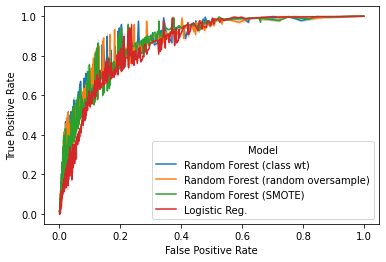

In [25]:
# brier_loss_RF.plot(x='Threshold',y=['BS','BS_ref'])
# brier_loss_OV.plot(x='Threshold',y=['BS','roc_vals_ALL.set_index(['BASIN']).xs('ALL')
sns.lineplot(data=roc_vals_ALL.set_index(['BASIN']).reset_index(),x='False Positive Rate',y='True Positive Rate',hue='Model')

In [26]:
y_pred_all_RF

,,,,,I_class,I_class label,Y pred,Y true,Predicted Basin,Model,Y pred probab (class: 0),Y pred probab (class: 1)
BASIN,ATCFID,CASE,NAME,DATE_full,,,,,,,,
EAST_PACIFIC,EP062019,15902.0,ERIC,2019-08-02 06:00:00,0.0,no RI,0.0,0.0,ALL,Random Forest (class wt),0.998051,0.001949
WEST_PACIFIC,WP172021,23050.0,WP17,2021-09-02 06:00:00,0.0,no RI,0.0,0.0,ALL,Random Forest (class wt),0.660819,0.339181
ATLANTIC,AL202021,13505.0,VICT,2021-09-30 00:00:00,0.0,no RI,1.0,0.0,ALL,Random Forest (class wt),0.467757,0.532243
WEST_PACIFIC,WP262019,22143.0,WP26,2019-11-14 00:00:00,1.0,RI,0.0,1.0,ALL,Random Forest (class wt),0.852827,0.147173
SOUTHERN_HEM,SH262019,14286.0,SH26,2019-05-07 18:00:00,0.0,no RI,0.0,0.0,ALL,Random Forest (class wt),0.741539,0.258461
...,...,...,...,...,...,...,...,...,...,...,...,...
WEST_PACIFIC,WP282021,23324.0,WP28,2021-12-19 00:00:00,0.0,no RI,0.0,0.0,ALL,Random Forest (class wt),0.972306,0.027694
SOUTHERN_HEM,SH262019,14294.0,SH26,2019-05-09 18:00:00,0.0,no RI,0.0,0.0,ALL,Random Forest (class wt),0.877701,0.122299
EAST_PACIFIC,EP052020,16190.0,CRIS,2020-07-09 18:00:00,0.0,no RI,0.0,0.0,ALL,Random Forest (class wt),0.686189,0.313811


#### Test best-guess model on 2019-2021 

<AxesSubplot:xlabel='BASIN', ylabel='Threat'>

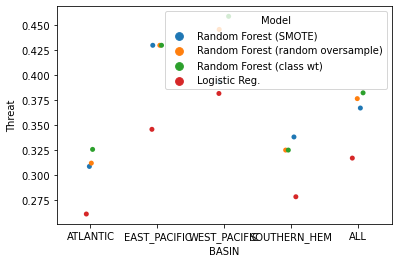

In [27]:
sns.stripplot(data=cm_ALL.set_index(['Category Names','BASIN','Model']).xs('RI').reset_index(),
            x='BASIN',y='Threat',hue='Model')

#### Save results (inc. trained model)

In [28]:
save_dir = 'trained_models/'
# save_dir = save_dir+model_type+'/TCBench_2025/'
save_extension = 'TEST_SHIPS_vs_no_RI_{yr_start}-{yr_end}_{mask_TYPE}_{stand_str}_RI_thresh_{RI_thresh}'\
'_{scoring}.csv'.format(yr_start=yr_start_TEST,yr_end=yr_end_LOAD,mask_TYPE=mask_TYPE,
                           stand_str=stand_str,RI_thresh=RI_thresh,scoring=scoring)
save_ext_figs = 'TEST_SHIPS_SIMPLE_RI_vs_no_RI_{yr_start}-{yr_end}_{mask_TYPE}_{stand_str}_RI_thresh_{RI_thresh}'\
'_{scoring}.png'.format(yr_start=yr_start_TEST,yr_end=yr_end_LOAD,mask_TYPE=mask_TYPE,
                           stand_str=stand_str,RI_thresh=RI_thresh,scoring=scoring)

In [29]:
save_extension

'TEST_SHIPS_vs_no_RI_2019-2021_SIMPLE_MASK_STANDARDIZED_RI_thresh_30_f1_weighted.csv'

##### Create subdirectories if they don't exist and save everything

In [30]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
# figs directory
if not os.path.exists(save_dir+'/figs/'):
    os.makedirs(save_dir+'/figs/')

In [31]:
predicted_y_ALL.to_csv(save_dir+'PREDICTED_Y_vals'+save_extension)
print('saved y vals')
roc_vals_ALL.to_csv(save_dir+'ROC_AUC_vals'+save_extension)
print('saved ROC vals')
p_vs_r_ALL.to_csv(save_dir+'Prec_vs_recall'+save_extension)
print('saved precision / recall values')
fi_pred_ALL.to_csv(save_dir+'Feat_Imp_validation'+save_extension)
print('saved feat importances')
fi_pred_train_ALL.to_csv(save_dir+'Feat_Imp_TRAIN'+save_extension)
print('saved feat importances (training)')
cm_ALL.to_csv(save_dir+'Conf_Matrix'+save_extension)
print('saved confusion matrix')
report_ALL.to_csv(save_dir+'Class_Report'+save_extension)
print('saved classification report ',save_dir+'Class_Report'+save_extension)

saved y vals
saved ROC vals
saved precision / recall values
saved feat importances
saved feat importances (training)
saved confusion matrix
saved classification report  DATA/ML_model_results/TESTING/all_models_ROS_and_SMOTE/TCBench_2025/Class_ReportTEST_SHIPS_vs_no_RI_2019-2021_SIMPLE_MASK_STANDARDIZED_RI_thresh_30_f1_weighted.csv


In [41]:
y_test.to_csv(save_dir+'SHIPS_RI_ground_truth_2019-21.csv')
X_test.to_csv(save_dir+'SHIPS_RI_features_2019-21.csv')

In [32]:
save_dir+'Conf_Matrix'+save_extension

'DATA/ML_model_results/TESTING/all_models_ROS_and_SMOTE/TCBench_2025/Conf_MatrixTEST_SHIPS_vs_no_RI_2019-2021_SIMPLE_MASK_STANDARDIZED_RI_thresh_30_f1_weighted.csv'

In [33]:
LR_model_fname = save_dir+'LOGISTIC_full_training_{yr_start}-{yr_end}_drop.sav'.format(yr_start=yr_start,yr_end=yr_end_TRAIN)
RF_cw_model_fname = save_dir+'RF_class_wt_full_training_{yr_start}-{yr_end}.sav'.format(yr_start=yr_start,yr_end=yr_end_TRAIN)
RF_ov_model_fname = save_dir+'RF_oversamp_full_training_{yr_start}-{yr_end}.sav'.format(yr_start=yr_start,yr_end=yr_end_TRAIN)
RF_smote_model_fname = save_dir+'RF_smote_full_training_{yr_start}-{yr_end}.sav'.format(yr_start=yr_start,yr_end=yr_end_TRAIN)
#
pickle.dump(LR_model,open(LR_model_fname,'wb'))
pickle.dump(RF_model,open(RF_cw_model_fname,'wb'))
pickle.dump(RF_model_ov,open(RF_smote_model_fname,'wb'))
pickle.dump(RF_model_ROS,open(RF_ov_model_fname,'wb'))

